# Torching
A jupyter notebook with an explained guide of the main usage of Pytorch for the use on deep neural networks, includes the explanation of:
- Tensors
- Autogradient

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.nn.functional as F # functions

from torch.optim import SGD

import numpy as np

## 1. Components: Tensors
- `tensor`: description and usage of the main component of the pytorch library, tensors.
    - slicing
    - adding
    - extracting components
    - usage of gpu

In [2]:
x = torch.rand(5,4) #quick way to write 5 rows 4 columns
x[:,:] # same syntax as numpy

tensor([[0.1540, 0.2919, 0.6738, 0.9603],
        [0.1930, 0.9253, 0.1474, 0.2778],
        [0.5735, 0.6061, 0.4994, 0.1900],
        [0.3704, 0.8745, 0.5590, 0.9525],
        [0.0901, 0.4051, 0.3087, 0.2974]])

In [3]:
# adding in place 
y = torch.rand(5,4)
y.add_(x) # y = y + x

tensor([[1.0609, 0.9023, 0.6845, 1.2616],
        [0.5467, 1.2641, 0.2741, 0.7459],
        [0.5960, 1.0776, 0.5522, 0.4293],
        [0.5038, 1.7216, 1.5103, 1.1305],
        [1.0793, 1.1765, 1.1255, 1.1213]])

In [4]:
z = x.view(-1, 10)
print(z)
print(z.size())

tensor([[0.1540, 0.2919, 0.6738, 0.9603, 0.1930, 0.9253, 0.1474, 0.2778, 0.5735,
         0.6061],
        [0.4994, 0.1900, 0.3704, 0.8745, 0.5590, 0.9525, 0.0901, 0.4051, 0.3087,
         0.2974]])
torch.Size([2, 10])


In [5]:
print(z[0,0])
print(x[0,0])
print("====")
z += 1 # modification of a view affects all, because they are pointers
print(z[0,0])
print(x[0,0])

tensor(0.1540)
tensor(0.1540)
====
tensor(1.1540)
tensor(1.1540)


In [6]:
x[1,1].item() # extract a number

1.9252870082855225

translate to numpy array, but they still share memory addres

In [7]:
A = torch.ones(3,3)
N = A.numpy()

print(A)
print(N)
print("====")
N += 1
print(A)
print(N)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
====
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


In [8]:
#construct from numpy
a  = np.ones((3,3))
b = torch.from_numpy(a) #share memory
c = torch.tensor(a) # new copy

a += 1
print(b)
print(c)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]], dtype=torch.float64)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


tensors can exist on cpu or gpu

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
%%timeit
x = torch.rand(5,4).to(device) # move (slower)


21.4 µs ± 3.23 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
%%timeit
z = torch.rand(5,4, device=device) # create inside selected device

9.68 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# 2. Autograd
autograd is an engine for computing the vector Jacobian product; that is taking their partial derivatives and applying chain rule

each operation done on a tensor that has `requires_grad` is tracked in a operation graph, important for the *backward propagation*

In [13]:
import torch

# requires_grad = True -> track all operations in operational graph
x = torch.rand(3, requires_grad = True)
y = x + 2

print(x)
print(y)
print(y.grad_fn)

tensor([0.6421, 0.1254, 0.8716], requires_grad=True)
tensor([2.6421, 2.1254, 2.8716], grad_fn=<AddBackward0>)


In [14]:
# executing more operations
z = y * y * 3
print(z)
z = z.mean()
print(z)

tensor([20.9415, 13.5523, 24.7379], grad_fn=<MulBackward0>)
tensor(19.7439, grad_fn=<MeanBackward0>)


In [15]:
print(x.grad)

# but calling LAST_TENSOR.backward() then with brack propagation
# does all the gradients automatically

z.backward()
print(x.grad) # dz/dx

# during optimization is important to reset this after an epoch
# optimizer.zero_grad() !!!

None
tensor([5.2841, 4.2508, 5.7432])


In [23]:
# for detaching, is creating a copy without the requires_grad
a = torch.rand(2,2, requires_grad = True)
b = a.detach()
print(a.requires_grad)
print(b.requires_grad)

True
False


In [24]:
# also we can create an environment without this gradient score
print(a.requires_grad)
with torch.no_grad():
    b = a**2
    print(b.requires_grad)

True
False


# 3. Gradient Descent Autograd
Linear rgression example:
$$
f(X) = W * X + B
$$

In [28]:
import torch

# for this model the real relation is f(X) = 2 * X
X = torch.tensor([i for i in range(1,10)], dtype=torch.float32)
Y = torch.tensor([2*i for i in range(1,10)], dtype=torch.float32)

# assuming only one weight ()
w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# run throught model
def forward(x):
    return w * x

# loss MSE (Mean Squared Error) L2 Norm
def loss(y, y_pred):
    return ( (y_pred - y)**2 ).mean()

X_test = 5.0
print(f'Initial prediction: f({X_test}) = {forward(X_test).item():.3f}')

Initial prediction: f(5.0) = 0.000


In [ ]:
# training
learning_rate = 0.01
n_epochs = 100

for epoch in range(n_epochs):
    # prediction = forward pass
    y_pred = forward(X)

    # loss
    L2 = loss(Y, y_pred)

    # backward propagation (calculate the gradients)
    L2.backward() #updates the gradient for w

    # update weights
    with torch.no_grad():   # updat w without impact
        w -= learning_rate * w.grad

    # zero the gradients after the update (cleaning)
    w.grad.zero_()

    if (epoch+1) % 10 == 0:
        print(f'epoch {int(epoch+1)}: w = {w.item():.3f}, \t loss= {L2.item():.3f}')

print(f'Prediction after training for {epoch+1} epochs: f({X_test}) = {forward(X_test).item():.3f}')


# 4Implementation of a Model

In [1]:
import torch
import torch.nn as nn

# they need to have at least two dimension, to extract number of data and features
X = torch.tensor([ [i] for i in range(10) ], dtype=torch.float32)
Y = torch.tensor([ [2*i] for i in range(10) ], dtype=torch.float32)

# Hyperparameters
N_epochs = 100
learning_rate = 0.01

n_data, n_features = X.size()
print(f"n_data: {n_data}; \t n_features: {n_features}")

n_data: 10; 	 n_features: 1


In [2]:
class LinearRegressor(nn.Module):
    """ model for linear regression """
    def __init__(self, input_dimension, output_dimension):
        super(LinearRegressor, self).__init__()
        # define the components to use to build
        # linear works for the W * X + B model
        self.lineal_1 = nn.Linear(input_dimension, output_dimension) 
    
    # then defines a forward method, 
    # defines how the data flows inside the network
    def forward(self, x):
        return self.lineal_1(x)

In [3]:
input_size, output_size = n_features, n_features

# here the method __init__ is used first
model = LinearRegressor(input_size, output_size)

# we can call their methods
y_pred = model.forward(X)
y_pred

tensor([[0.0052],
        [0.3577],
        [0.7101],
        [1.0626],
        [1.4151],
        [1.7676],
        [2.1201],
        [2.4725],
        [2.8250],
        [3.1775]], grad_fn=<AddmmBackward0>)

In [6]:
y_pred.detach()

tensor([[0.0052],
        [0.3577],
        [0.7101],
        [1.0626],
        [1.4151],
        [1.7676],
        [2.1201],
        [2.4725],
        [2.8250],
        [3.1775]])

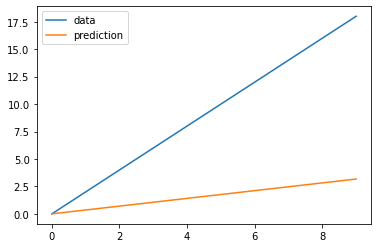

In [10]:
# see the difference of prediction
def plot_difference(X, Y, y_pred):
    import matplotlib.pyplot as plt

    plt.plot(X, Y, label="data")
    plt.plot(X, y_pred, label="prediction")
    plt.legend()
    plt.show()

plot_difference(X, Y, y_pred.detach())

In [4]:
# define a loss function
def loss_function(y_pred, y_data):
    """ uses MSE """
    return ( (y_pred - y_data)**2 ).mean()

L2_loss = loss_function( y_pred, Y )
L2_loss

tensor(77.2815, grad_fn=<MeanBackward0>)

training of this simple model,
occurs inside of `epoch`,

some things are neccesary which we were ommited,
- measuring prediction on already trained data produces lack of measure on overfitting